In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley
from shapkit.sgd_shapley import SGDshapley
from shapkit.plots import plot_shapley

from sklearn.ensemble import IsolationForest

# Load dataset

In [2]:
from sklearn.datasets import load_wine

wine = load_wine(return_X_y=False)
X = pd.DataFrame(wine.data, columns=wine.feature_names)
X.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0



# Train a ML model

In [3]:
model = IsolationForest(behaviour="new", contamination="auto")
model.fit(X)

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

# Define the game

In [4]:
d = X.shape[1]
n = 2**d - 2
d, n

(13, 8190)

## Reward function

def fc(z):
    if model.decision_function(z.reshape(1,-1)) < 0:
        return 1
    else:
        return 0

In [5]:
fc = lambda x: model.decision_function(x.reshape(1,-1))[0]

### Pick an anomaly $x$

In [6]:
idx_anomaly = np.argwhere(model.predict(X) == -1).flatten()
idx_x = np.random.choice(idx_anomaly, size=1)[0]
x = X.iloc[idx_x,:]
x_score = fc(x.values)
print(x)
print()
print("Prediction for x: {0:.2f}".format(x_score))

alcohol                          14.34
malic_acid                        1.68
ash                               2.70
alcalinity_of_ash                25.00
magnesium                        98.00
total_phenols                     2.80
flavanoids                        1.31
nonflavanoid_phenols              0.53
proanthocyanins                   2.70
color_intensity                  13.00
hue                               0.57
od280/od315_of_diluted_wines      1.96
proline                         660.00
Name: 158, dtype: float64

Prediction for x: -0.07


### Single reference in normal class

In [7]:
idx_normal = np.argwhere(model.predict(X) == 1).flatten()
idx_r = np.random.choice(idx_normal, size=1)[0]
reference = X.iloc[idx_r,:]
ref_score = fc(reference.values)
print(reference)
print()
print("Prediction for this reference: {0:.2f}".format(ref_score))

alcohol                          12.29
malic_acid                        3.17
ash                               2.21
alcalinity_of_ash                18.00
magnesium                        88.00
total_phenols                     2.85
flavanoids                        2.99
nonflavanoid_phenols              0.45
proanthocyanins                   2.81
color_intensity                   2.30
hue                               1.42
od280/od315_of_diluted_wines      2.83
proline                         406.00
Name: 99, dtype: float64

Prediction for this reference: 0.00


#### Approximation methods

##### Monte Carlo 

In [8]:
mc_shap = MonteCarloShapley(x=x, fc=fc, ref=reference, n_iter=100)
mc_shap

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


alcohol                        -0.017569
malic_acid                      0.010815
ash                            -0.007425
alcalinity_of_ash              -0.015121
magnesium                       0.007766
total_phenols                   0.000179
flavanoids                      0.002012
nonflavanoid_phenols           -0.013370
proanthocyanins                 0.003338
color_intensity                -0.050035
hue                             0.006877
od280/od315_of_diluted_wines   -0.004844
proline                         0.002000
dtype: float64

##### SGD

In [9]:
sgd_est = SGDshapley(d, C=1)
sgd_shap = sgd_est.sgd(x=x, fc=fc, ref=reference, n_iter=50, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 50/50 [00:03<00:00, 14.04it/s]


alcohol                        -0.011689
malic_acid                     -0.002989
ash                            -0.004815
alcalinity_of_ash              -0.004930
magnesium                      -0.002592
total_phenols                  -0.003496
flavanoids                     -0.006079
nonflavanoid_phenols           -0.003532
proanthocyanins                -0.004181
color_intensity                -0.028646
hue                             0.004210
od280/od315_of_diluted_wines   -0.001485
proline                        -0.005151
dtype: float64

#### Plot 

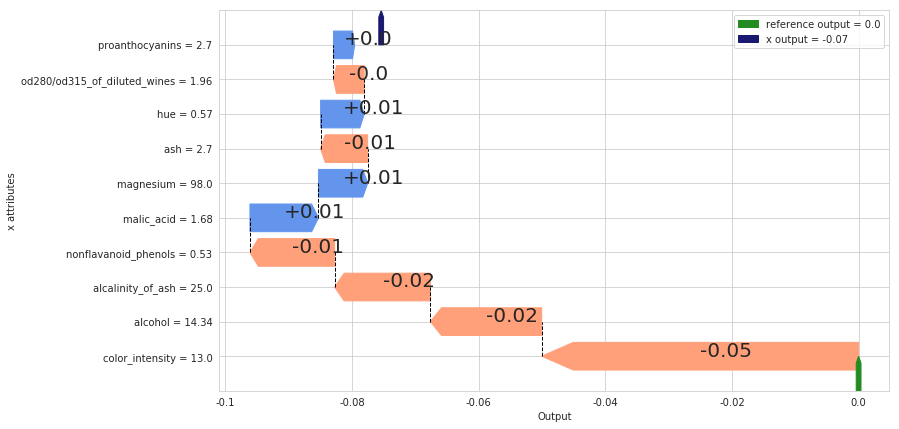

In [10]:
plot_shapley(x=x, fc=fc, ref=reference, shapley_values=mc_shap, n_attributes=10)

### Several references 

In [11]:
n_ref = 10
idx_normal = np.argwhere(model.predict(X) == 1).flatten()
idx_ref = np.random.choice(idx_normal, size=n_ref, replace=False).flatten()
references = X.iloc[idx_ref,:]
references.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
72,13.49,1.66,2.24,24.0,87.0,1.88,1.84,0.27,1.03,3.74,0.98,2.78,472.0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0
98,12.37,1.07,2.10,18.5,88.0,3.52,3.75,0.24,1.95,4.50,1.04,2.77,660.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
109,11.61,1.35,2.70,20.0,94.0,2.74,2.92,0.29,2.49,2.65,0.96,3.26,680.0


#### Approximation methods

##### Monte Carlo 

In [12]:
mc_shaps = MonteCarloShapley(x=x, fc=fc, ref=references, n_iter=100)
mc_shaps

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


alcohol                        -0.018471
malic_acid                      0.007982
ash                            -0.004432
alcalinity_of_ash              -0.015197
magnesium                       0.005870
total_phenols                  -0.000107
flavanoids                     -0.000731
nonflavanoid_phenols           -0.015966
proanthocyanins                -0.017512
color_intensity                -0.051001
hue                            -0.013582
od280/od315_of_diluted_wines   -0.004515
proline                         0.000915
dtype: float64

#### Plots

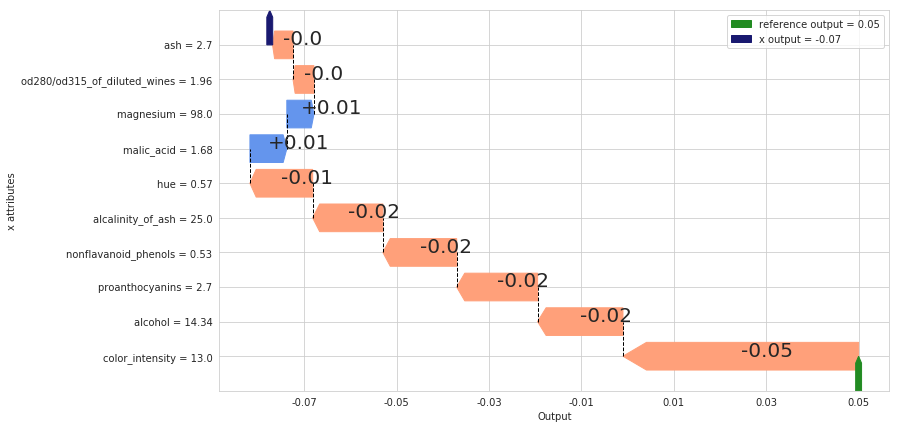

In [13]:
plot_shapley(x=x, fc=fc, ref=references, shapley_values=mc_shaps, n_attributes=10)